# **Análisis Exploratorio de Datos**

##  *Sobre el dataset*

El archivo **`btc_1d_data_2018_to_2025.csv`** contiene **datos históricos diarios de Bitcoin**, incluyendo:

-  **Fecha de apertura** (*Open time*)  
-  **Precio de apertura, máximo, mínimo y cierre** (*Open, High, Low, Close*)  
-  **Volumen negociado** y **número de transacciones**  
-  **Información de compradores agresivos** (*Taker buy volume*)  


👉 Para este análisis, se utilizarán exclusivamente las columnas:  

- **Date**  
- **Close**  

Esto en línea con la restricción metodológica de trabajar únicamente con el **histórico de precios de cierre**.


# **Carga y limpieza de datos**

In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np 

In [137]:
btc_raw = pd.read_csv("../data/btc_1d_data_2018_to_2025.csv")
btc_raw

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2018-01-01,13715.65,13818.55,12750.00,13380.00,8609.915844,2018-01-01 23:59:59.999,1.147997e+08,105595,3961.938946,5.280975e+07,0
1,2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111,2018-01-02 23:59:59.999,2.797171e+08,177728,11346.326739,1.580801e+08,0
2,2018-01-03,14690.00,15307.56,14150.00,14919.51,15905.667639,2018-01-03 23:59:59.999,2.361169e+08,162787,8994.953566,1.335873e+08,0
3,2018-01-04,14919.51,15280.00,13918.04,15059.54,21329.649574,2018-01-04 23:59:59.999,3.127816e+08,170310,12680.812951,1.861168e+08,0
4,2018-01-05,15059.56,17176.24,14600.00,16960.39,23251.491125,2018-01-05 23:59:59.999,3.693220e+08,192969,13346.622293,2.118299e+08,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2589,2025-02-02,100635.66,101456.60,99747.59,99796.00,3149.622330,2025-02-02 23:59:59.999,3.167280e+08,558753,1223.084700,1.231618e+08,0
2590,2025-02-03,97700.59,97782.79,91231.00,94495.21,20992.955720,2025-02-03 23:59:59.999,1.983835e+09,2309956,9239.171560,8.738586e+08,0
2591,2025-02-04,101328.51,101660.94,100743.33,101367.77,1910.355420,2025-02-04 23:59:59.999,1.933988e+08,208849,822.417140,8.326802e+07,0
2592,2025-02-05,97763.14,98930.44,97131.43,97589.30,8160.567950,2025-02-05 23:59:59.999,7.990502e+08,1597813,3672.410530,3.596230e+08,0


## *Selección de Variables*

En la primera fase del análisis exploratorio se depura el dataset **btc_raw**, conservando únicamente las columnas:

-  **Date** (antes *Open time*, convertida a `datetime`)  
-  **Close** (convertida a `float`)  

Esto asegura: 

-  **Relevancia temporal**: facilita operaciones cronológicas, *resampling* y generación de *lags*.  
-  **Consistencia numérica**: garantiza precisión en cálculos de retornos, medias móviles y volatilidad.  
-  **Reducción de dimensionalidad**: elimina variables irrelevantes, simplificando el DataFrame y mejorando la eficiencia.  

 Con esta limpieza inicial se establece una base **sólida, precisa y lista** para el análisis financiero posterior.

In [138]:
# Nos quedamos únicamente con la fecha de apertura y el precio de cierre
btc = btc_raw[['Open time', 'Close']].copy()

# Renombramos la columna de fecha para mayor claridad
btc.rename(columns={'Open time': 'Date'}, inplace=True)

# Convertimos la fecha a tipo datetime
btc['Date'] = pd.to_datetime(btc['Date'])

btc.set_index('Date', inplace=True)

# Aseguramos que el precio de cierre sea tipo float
btc['Close'] = btc['Close'].astype(float)

# Cálculo del retorno logarítmico diario
btc['LogReturn'] = np.log(btc['Close'] / btc['Close'].shift(1))


btc.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2594 entries, 2018-01-01 to 2025-02-06
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      2594 non-null   float64
 1   LogReturn  2593 non-null   float64
dtypes: float64(2)
memory usage: 60.8 KB


## *Revisión de valores faltantes* 

In [ ]:
btc.isnull().sum()

Close        0
LogReturn    1
dtype: int64

Se realizó un conteo de valores nulos por columna para garantizar la integridad del dataset antes de las transformaciones estadísticas. El resultado confirmó que no existen valores faltantes en **Date** ni en **Close**, lo que permite avanzar con confianza al cálculo de retornos, volatilidad y generación de *features*.  

# **Estadística descriptiva**

## *Precio de cierre*

In [141]:
btc_close_summary = pd.DataFrame({
    'Estadística': [
        'Media',
        'Mediana',
        'Desviación estándar',
        'Mínimo',
        'Máximo',
        'Rango',
        'Cuartil 25%',
        'Cuartil 50%',
        'Cuartil 75%'
    ],
    'Valor': [
        btc['Close'].mean(),
        btc['Close'].median(),
        btc['Close'].std(),
        btc['Close'].min(),
        btc['Close'].max(),
        btc['Close'].max() - btc['Close'].min(),
        btc['Close'].quantile(0.25),
        btc['Close'].quantile(0.50),
        btc['Close'].quantile(0.75)
    ]
})

styled_table = (
    btc_close_summary.style
    .format({'Valor': '{:,.2f}'})
    .background_gradient(subset=['Valor'], cmap='Purples')
    .set_properties(**{'text-align': 'left'})
)

styled_table



,Estadística,Valor
0,Media,"29,090.19"
1,Mediana,"22,741.11"
2,Desviación estándar,"23,576.23"
3,Mínimo,"3,211.72"
4,Máximo,"106,143.82"
5,Rango,"102,932.10"
6,Cuartil 25%,"9,068.84"
7,Cuartil 50%,"22,741.11"
8,Cuartil 75%,"43,527.39"


In [142]:
btc_date_range = pd.DataFrame({
    'Estadística': ['Rango temporal'],
    'Valor': [f"{btc.index.min().date()} → {btc.index.max().date()}"]
})

# Mostrar ambas tablas
btc_close_summary.style.format({'Valor': '{:,.2f}'}).background_gradient(subset=['Valor'], cmap='Purples')
btc_date_range

,Estadística,Valor
0,Rango temporal,2018-01-01 → 2025-02-06


Se analizaron los precios de cierre de **BTC** entre el **1 de enero de 2018** y el **6 de febrero de 2025**, con un total de **2,594 observaciones diarias**. El análisis revela que el precio presenta una **media de $29,090** y una **mediana de $22,741**, lo que sugiere una distribución asimétrica positiva. La **desviación estándar de $23,576** evidencia una fuerte dispersión y confirma la alta volatilidad del activo.  

El rango alcanza los **$102,932**, con valores mínimos de **$3,211** y máximos de **$106,143**, lo que refleja la magnitud de los ciclos de mercado. Además, el **50% de los precios** se concentra entre **$9,068 y $43,527**, mostrando una marcada variabilidad en niveles intermedios con colas largas.  



## *Retornos logarítmicos* 

In [ ]:
btc_logret_summary = pd.DataFrame({
    'Estadística': [
        'Media',
        'Mediana',
        'Desviación estándar',
        'Mínimo',
        'Máximo',
        'Rango',
        'Cuartil 25%',
        'Cuartil 50%',
        'Cuartil 75%',
        'Retorno acumulado',
        'Rendimiento total (%)'
    ],
    'Valor': [
        btc['LogReturn'].mean(),
        btc['LogReturn'].median(),
        btc['LogReturn'].std(),
        btc['LogReturn'].min(),
        btc['LogReturn'].max(),
        btc['LogReturn'].max() - btc['LogReturn'].min(),
        btc['LogReturn'].quantile(0.25),
        btc['LogReturn'].quantile(0.50),
        btc['LogReturn'].quantile(0.75),
        btc['LogReturn'].sum(),
        (np.exp(btc['LogReturn'].sum()) - 1) * 100  
    ]
})

styled_logret_table = (
    btc_logret_summary.style
    .format({'Valor': '{:,.6f}'})
    .background_gradient(subset=['Valor'], cmap='Purples')
    .set_properties(**{'text-align': 'left'})
)

styled_logret_table

,Estadística,Valor
0,Media,0.000769
1,Mediana,0.000708
2,Desviación estándar,0.036221
3,Mínimo,-0.502607
4,Máximo,0.178449
5,Rango,0.681056
6,Cuartil 25%,-0.014171
7,Cuartil 50%,0.000708
8,Cuartil 75%,0.016304
9,Retorno acumulado,1.994559


El análisis de los **retornos logarítmicos diarios de BTC** muestra una dinámica marcada por **alta volatilidad**, **colas pesadas** y **asimetría**.

La **media (0.00077)** y la **mediana (0.00071)** son positivas pero cercanas a cero, lo que indica ligeros rendimientos diarios en promedio, con cierta simetría central. Sin embargo, la **desviación estándar (0.0362)** confirma una fuerte dispersión: el retorno mínimo (−50%) evidencia caídas abruptas, mientras que el máximo (≈18%) señala alzas notables pero menos extremas, lo que revela una **asimetría negativa**.  

En términos de dispersión intermedia, el **50% de los retornos diarios** se ubica entre −1.4% y +1.6%, mostrando movimientos moderados en la mayoría de los días, aunque los **extremos frecuentes** refuerzan la existencia de colas pesadas.  

El **retorno acumulado** es significativo: la suma de log-retornos (≈1.995) equivale a un rendimiento total de **≈634.8%** en el periodo, lo que valida a BTC como un activo de alto crecimiento, aunque acompañado de alto riesgo.


## *Evolución anual del precio y retornos del BTC*

In [ ]:
# Extraemos el año como nueva columna
btc['Year'] = btc.index.year

# Agrupamos por año y calculamos estadísticas
annual_stats = btc.groupby('Year').agg({
    'Close': ['mean', 'std', 'min', 'max'],
    'LogReturn': ['mean', 'std']
})

annual_stats.columns = ['Close_mean', 'Close_std', 'Close_min', 'Close_max', 'LogReturn_mean', 'LogReturn_std']
annual_stats = annual_stats.round(4)
annual_stats


,Close_mean,Close_std,Close_min,Close_max,LogReturn_mean,LogReturn_std
Year,,,,,,
2018,7538.1139,2404.4230,3211.72,17069.79,-0.0035,0.0440
2019,7364.3632,2646.5728,3398.40,13093.80,0.0018,0.0357
2020,11110.5485,4309.4733,4800.00,28923.63,0.0038,0.0424
2021,47400.0030,9770.9924,29331.69,67525.83,0.0013,0.0424
2022,28185.2179,10188.5129,15781.29,47722.65,-0.0028,0.0337
2023,28849.5918,5901.6370,16616.75,44170.99,0.0026,0.0228
2024,65963.5927,14679.3342,39568.02,106133.74,0.0022,0.0276
2025,99803.1170,3807.7701,92552.49,106143.82,0.0013,0.0276


Esta tabla resume la dinámica anual del precio de cierre de BTC y sus retornos logarítmicos, permitiendo identificar **cambios estructurales**, **ciclos de volatilidad** y **tendencias de crecimiento**.  


### 🔹 2018–2019 
- **Precio promedio**: alrededor de $7,500  
- **Retorno medio**: negativo en 2018 (−0.0035), positivo en 2019 (0.0018)  
- **Volatilidad**: alta en ambos años, con desviaciones estándar > 0.035  
- **Interpretación**: BTC inicia en fase bajista tras el pico de 2017; 2018 refleja corrección prolongada, mientras que 2019 muestra recuperación. La dispersión elevada confirma un mercado inestable.  


### 🔹 2020–2021 
- **Precio promedio**: $11,110 en 2020 y se cuadruplica en 2021  
- **Retorno medio**: positivo y creciente (0.0038 en 2020)  
- **Volatilidad**: elevada (~0.042)  
- **Interpretación**: en 2020, los estímulos monetarios e interés institucional impulsan el precio. 2021 marca un ciclo especulativo con máximos históricos; los retornos se moderan pero la volatilidad persiste.  


### 🔹 2022 
- **Precio promedio**: cae a $28,185  
- **Retorno medio**: negativo (−0.0028)  
- **Volatilidad**: ligeramente menor  
- **Interpretación**: tras el rally de 2021, el mercado entra en fase de corrección. Los precios y retornos caen, pero la volatilidad aún es significativa.  


### 🔹 2023–2025  
- **Precio promedio**: estable en 2023 (~$28,850), con fuerte alza en 2024 y 2025  
- **Retorno medio**: positivo pero más moderado  
- **Volatilidad**: en descenso (0.0228 en 2023, 0.0276 en 2025)  
- **Interpretación**: BTC muestra maduración; precios alcanzan nuevos máximos, retornos diarios son más estables y la volatilidad disminuye, posiblemente por mayor liquidez y participación institucional.  

In [ ]:
annual_stats.columns = annual_stats.columns.to_flat_index()
annual_stats.columns = [
    'Precio promedio (USD)',
    'Desviación estándar del precio',
    'Precio mínimo',
    'Precio máximo',
    'Retorno logarítmico promedio',
    'Desviación estándar del retorno'
]


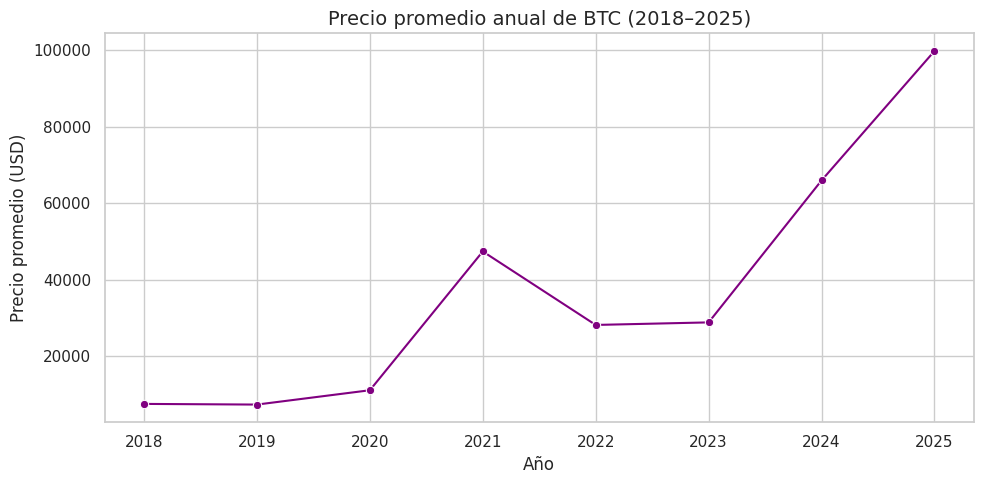

In [146]:
sns.set(style='whitegrid', palette='Purples')

# Gráfico de líneas del precio promedio anual
plt.figure(figsize=(10, 5))
sns.lineplot(data=annual_stats, x=annual_stats.index, y='Precio promedio (USD)', marker='o', color='purple')
plt.title('Precio promedio anual de BTC (2018–2025)', fontsize=14)
plt.xlabel('Año')
plt.ylabel('Precio promedio (USD)')
plt.xticks(annual_stats.index)
plt.tight_layout()
plt.show()

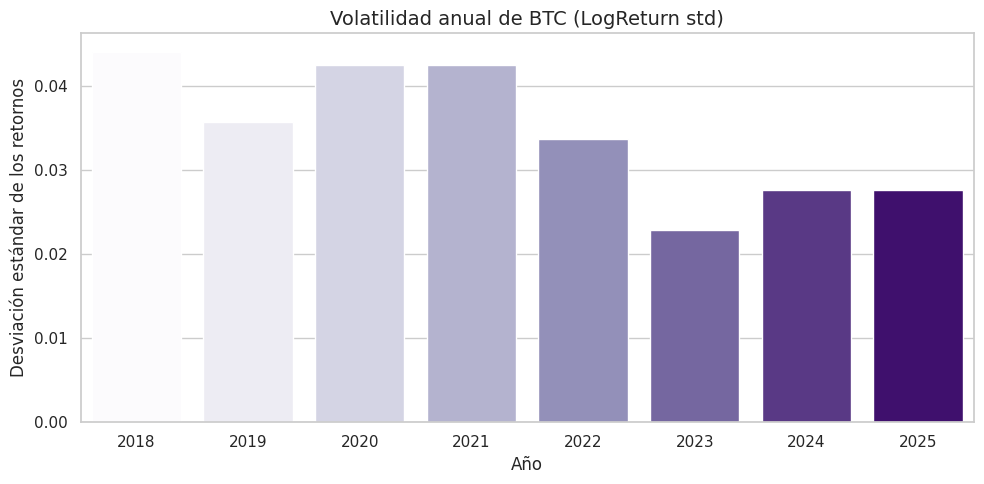

In [147]:
# Gráfico de barras de la volatilidad anual
plt.figure(figsize=(10, 5))
sns.barplot(x=annual_stats.index, y='Desviación estándar del retorno', data=annual_stats, palette='Purples', hue=annual_stats.index, legend= False)
plt.title('Volatilidad anual de BTC (LogReturn std)', fontsize=14)
plt.xlabel('Año')
plt.ylabel('Desviación estándar de los retornos')
plt.tight_layout()
plt.show() 


- **Evolución del precio promedio:**  
  El primer gráfico revela cómo el **precio promedio anual** ha evolucionado, con saltos destacados en **2021, 2024 y 2025**, lo que refleja los principales ciclos alcistas de BTC.  

- **Volatilidad del mercado:**  
  El segundo gráfico muestra cómo la **volatilidad ha disminuido progresivamente desde 2021**, lo que sugiere una **posible maduración del mercado** con retornos más estables.  

# **Visualizaciones**

## *Serie temporal del precio de cierre*

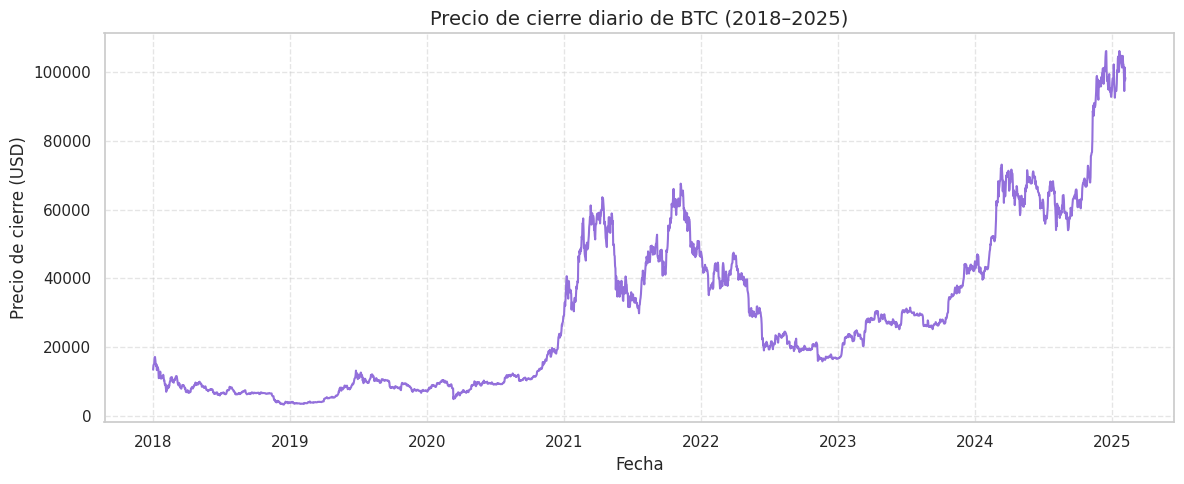

In [149]:
plt.figure(figsize=(12, 5))
plt.plot(btc.index, btc['Close'], color='#9370DB') 
plt.title("Precio de cierre diario de BTC (2018–2025)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre (USD)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



### Tendencias generales de BTC

- **2018–2020**: Periodo de relativa estabilidad con precios entre **$3,000 y $10,000 USD**.
- **2021**: Aumento abrupto con máximos de **$60,000–$65,000 USD**.
- **2022–2023**: Etapa de **fuerte corrección**, con caídas pronunciadas. 
- **2024–2025**: Nuevo **ciclo alcista**, con precios que superan los **$100,000 USD**.

###  Volatilidad de BTC

- El gráfico evidencia una alta volatilidad estructural, con movimientos bruscos tanto al alza como a la baja.
- Los picos y valles son frecuentes, lo que refuerza la necesidad de modelar no solo el precio, sino también su volatilidad como variable objetivo.

Para fines de modelado, esto implica la necesidad de incluir lags temporales, modelos multisalida y técnicas capaces de capturar dependencias no lineales, así como considerar mecanismos de regularización y detección de cambios estructurales. 


## *Histograma de precios*

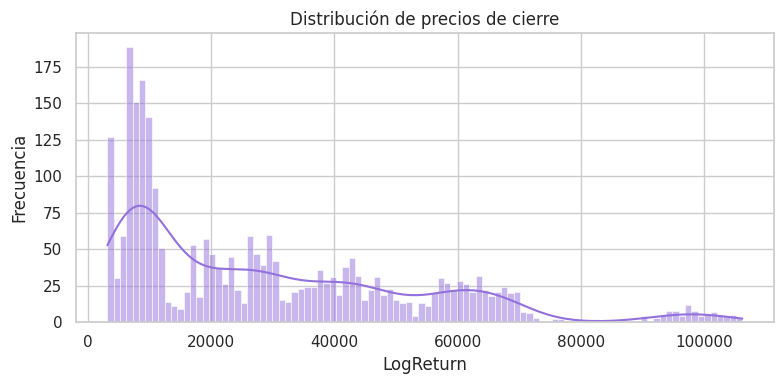

In [150]:
plt.figure(figsize=(8, 4))
sns.histplot(btc['Close'], bins=100, kde=True, color='#9370DB')
plt.title("Distribución de precios de cierre")
plt.xlabel("LogReturn")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

## *Serie de retornos*

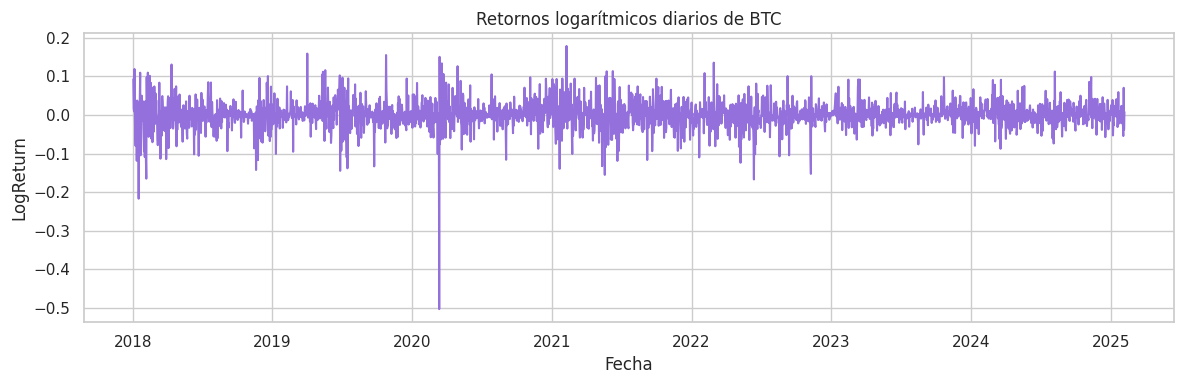

In [152]:
plt.figure(figsize=(12, 4))
plt.plot(btc.index, btc['LogReturn'], color='#9370DB')
plt.title("Retornos logarítmicos diarios de BTC")
plt.xlabel("Fecha")
plt.ylabel("LogReturn")
plt.grid(True)
plt.tight_layout()
plt.show()


### *Comportamiento de los retornos*

- La serie de retornos oscila alrededor de **cero**, como es habitual en activos financieros.  
- Se aprecian **picos abruptos** positivos y negativos que reflejan movimientos extremos en el precio.  
- Un evento destacado ocurre en **2020**, el cual más adelante veremos especialmente junto a otros picos extremos.

### *Volatilidad agrupada*

- Aunque los retornos parecen aleatorios, se distinguen periodos de **alta intensidad** seguidos de fases más tranquilas.  
- Este comportamiento confirma la **heterocedasticidad**, es decir, la varianza no es constante en el tiempo. Se verá con más detalle a continuación.  
- Ello justifica el uso de métricas como **rolling std** o modelos de volatilidad como **GARCH**.  



### *Posibles explicaciones de los picos abruptos*

- Picos negativos


In [153]:
btc.sort_values(by='LogReturn').head(5)


,Close,LogReturn,Year
Date,,,
2020-03-12,4800.00,-0.502607,2020
2018-01-16,10900.00,-0.216880,2018
2022-06-13,22487.41,-0.166998,2022
2018-02-05,6939.99,-0.164980,2018
2021-05-19,36690.09,-0.155194,2021


| Fecha       | Retorno logarítmico | Caída aprox. | Contexto                                                                 | Impacto                                                                                     |
|-------------|---------------------|--------------|--------------------------------------------------------------------------|---------------------------------------------------------------------------------------------|
| 2020-03-12  | −0.5026             | −39.6%       | *“Jueves negro”* del COVID-19: venta masiva global de activos de riesgo.  | Inicio del bull market 2020-21. BTC pasó de desplome a activo **antifrágil** frente al QE.   |
| 2018-01-16  | −0.2169             | −19.5%       | *“Crypto Carnage”* por rumores de regulaciones en Corea del Sur.          | Señal clara del **cambio de ciclo**. Inicio del bear market con pérdidas >80% posteriores.   |
| 2022-06-13  | −0.1670             | −15.4%       | Bloqueo de retiros en Celsius y contagio tras colapso de Terra/Luna.      | Aceleración del bear market 2022. Quiebras de CeFi y auge de **autocustodia/DeFi**.         |
| 2018-02-05  | −0.1650             | −15.2%       | Segunda ola de corrección de 2018 con presión regulatoria en Asia.        | Confirmó la **tendencia bajista**. Golpe psicológico que consolidó el fin del rally 2017.   |
| 2021-05-19  | −0.1552             | −14.4%       | China refuerza restricciones y prohíbe servicios financieros con cripto.  | **Éxodo del hashrate** hacia Occidente. Red más descentralizada y resiliente a mediano plazo.|


- Picos positivos

In [154]:
btc.sort_values(by='LogReturn', ascending=False).head(5)


,Close,LogReturn,Year
Date,,,
2021-02-08,46374.87,0.178449,2021
2019-04-02,4857.29,0.158684,2019
2019-10-25,8655.02,0.154984,2019
2020-03-13,5578.60,0.150322,2020
2022-02-28,43160.00,0.135279,2022


| Fecha       | Retorno logarítmico | Subida aprox. | Contexto                                                                | Impacto                                                                                   |
|-------------|---------------------|---------------|-------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| 2021-02-08  | +0.1784             | +19.5%        | Tesla anuncia compra de $1.5B en BTC y que aceptará pagos en cripto.    | Nuevo máximo histórico >$46k. Punto de inflexión para la **adopción institucional**.      |
| 2019-04-02  | +0.1587             | +17.2%        | Ruptura técnica de resistencia en $4,200 con activación de órdenes.     | Rally inmediato a $4,800. Señal del fin del **bear market 2018**.                         |
| 2019-10-25  | +0.1550             | +16.7%        | Xi Jinping promueve el blockchain como tecnología estratégica en China. | Interpretado como respaldo indirecto a BTC. Subida a ~$10,300 en un solo día.             |
| 2020-03-13  | +0.1503             | +16.2%        | Rebote técnico tras el *crash* del COVID-19 del 12 de marzo.            | Recuperación parcial: de ~$3,800 a ~$5,500. Inicio de una recuperación sostenida.         |
| 2022-02-28  | +0.1353             | +14.5%        | Estalla la guerra en Ucrania. Kiev recibe donaciones en BTC y ETH.      | BTC usado como activo refugio. Crece el trading en rublos y hryvnias.                     |


## *Histograma de retornos*

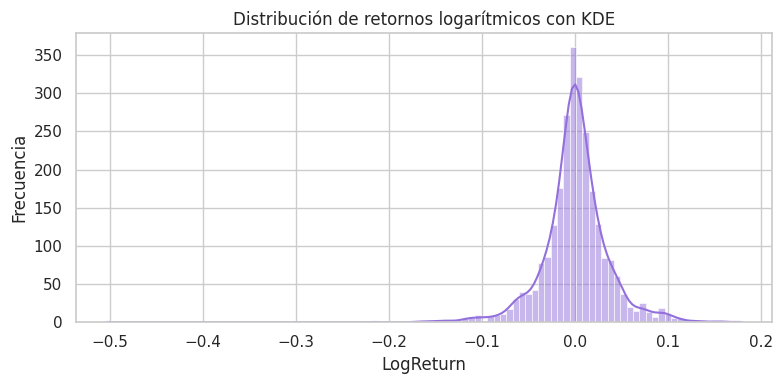

In [155]:
plt.figure(figsize=(8, 4))
sns.histplot(btc['LogReturn'], bins=100, kde=True, color='#9370DB')
plt.title("Distribución de retornos logarítmicos con KDE")
plt.xlabel("LogReturn")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()


El gráfico muestra que la mayoría de los retornos diarios de Bitcoin se concentran cerca de cero, reflejando movimientos pequeños en la mayor parte del tiempo. Sin embargo, presenta una asimetría negativa, ya que las caídas tienden a ser más intensas que las subidas, con una cola izquierda más larga que evidencia episodios de pérdidas abruptas como los del 12 de marzo de 2020 o el 16 de enero de 2018. Este comportamiento es característico de activos financieros altamente volátiles, cuya distribución se centra en cero pero presenta colas pesadas, lo que sugiere un riesgo significativo de movimientos extremos.

Para corroborar estas observaciones, se calcularán medidas estadísticas de forma, como la **asimetría** y la **curtosis**, que permiten cuantificar el sesgo hacia caídas más extremas y la presencia de colas pesadas en la distribución de los retornos.



In [156]:
logret = btc['LogReturn'].dropna() 

In [157]:
from scipy.stats import skew, kurtosis

print("Asimetría (Skewness):", skew(logret))
print("Curtosis:", kurtosis(logret))


Asimetría (Skewness): -1.1575570438518914
Curtosis: 17.01619756942232


El análisis de forma de la distribución de los retornos muestra una **asimetría (skewness) de −1.16**, lo que confirma una cola más larga hacia la izquierda: las caídas abruptas son más frecuentes o intensas que las subidas equivalentes. Asimismo, la **curtosis de 17.02** (muy superior al valor de 3 en una normal) revela colas pesadas y una alta probabilidad de eventos extremos. Estos resultados corroboran que la distribución de BTC no es normal en sentido estadístico, lo que justifica el uso de **modelos robustos para volatilidad** y métricas de evaluación no dependientes de supuestos de normalidad (MAE, MAPE, percentiles).


## *ACF de LogReturn*

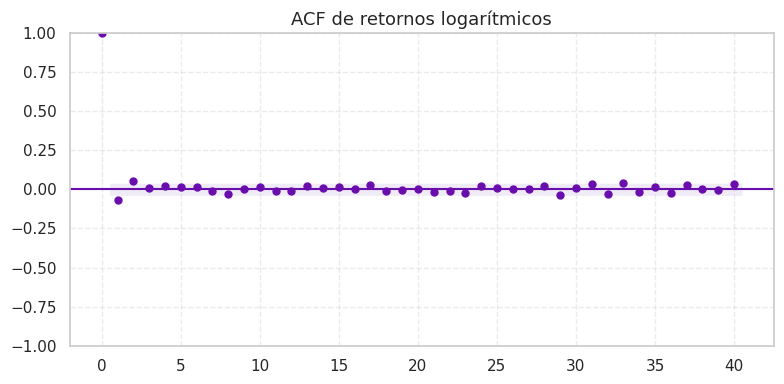

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

plot_acf(logret, lags=40, ax=ax)

for line in ax.lines:
    line.set_color('#6a0dad')

for patch in ax.patches:
    patch.set_facecolor('#6a0dad')
    patch.set_alpha(0.6)

for polygon in ax.collections:
    polygon.set_facecolor('#b19cd9')  
    polygon.set_alpha(0.2)

ax.set_title("ACF de retornos logarítmicos", fontsize=13)
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



La autocorrelación en lag 0 es naturalmente alta (valor 1), ya que representa la correlación de la serie consigo misma. Para lags mayores a 0, los valores están muy cerca de cero, lo que indica que los retornos logarítmicos diarios de BTC son prácticamente independientes en el tiempo, sugiriendo un comportamiento cercano al ruido blanco y respaldando la hipótesis de eficiencia del mercado. Para cuantificar estadísticamente esta independencia, se aplicará la **prueba de Ljung-Box**, la cual evalúa si existe autocorrelación significativa en los lags seleccionados, permitiendo determinar de manera objetiva si los retornos diarios se comportan como ruido blanco. 


In [159]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test de Ljung-Box para los retornos
ljung_ret = acorr_ljungbox(logret, lags=[10], return_df=True)
print("Ljung-Box para LogReturn:\n", ljung_ret)


Ljung-Box para LogReturn:
       lb_stat  lb_pvalue
10  23.785027   0.008192


Para los retornos logarítmicos diarios de BTC, el p-valor de la prueba de Ljung-Box es 0.008, lo que indica una dependencia leve pero significativa hasta el lag 10. Aunque la ACF mostraba visualmente poca autocorrelación, este resultado sugiere la existencia de patrones sutiles que no son evidentes a simple vista. Esto enfatiza la necesidad de un análisis más profundo si se busca modelar cualquier dependencia temporal en los retornos.


## *ACF de LogReturn²*

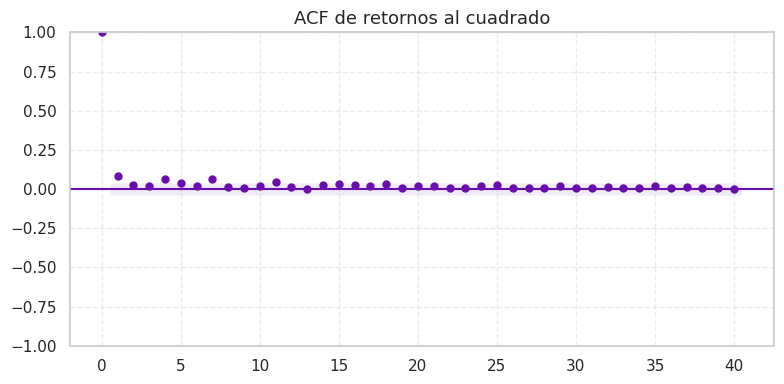

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

# Graficar ACF de retornos al cuadrado
plot_acf(logret**2, lags=40, ax=ax)

for line in ax.lines:
    line.set_color('#6a0dad')  

for patch in ax.patches:
    patch.set_facecolor('#6a0dad')
    patch.set_alpha(0.6)

for polygon in ax.collections:
    polygon.set_facecolor('#b19cd9') 
    polygon.set_alpha(0.2)

ax.set_title("ACF de retornos al cuadrado", fontsize=13)
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



La autocorrelación de los retornos al cuadrado muestra que, aunque la mayoría de los lags se encuentran dentro del intervalo de confianza, existe una persistencia leve en los primeros lags. Esto indica que la volatilidad tiende a agruparse en el tiempo, un fenómeno conocido como *volatility clustering*, típico en activos financieros: días con alta volatilidad suelen ser seguidos por otros días también volátiles. Para cuantificar formalmente esta dependencia temporal, se aplicará la prueba de **Ljung-Box**, que permitirá evaluar si la autocorrelación observada es estadísticamente significativa.



In [161]:
# Test de Ljung-Box para los retornos al cuadrado
ljung_ret2 = acorr_ljungbox(logret**2, lags=[10], return_df=True)
print("Ljung-Box para LogReturn²:\n", ljung_ret2)


Ljung-Box para LogReturn²:
      lb_stat     lb_pvalue
10  50.45701  2.199140e-07


Para los retornos al cuadrado, el p-valor del test de Ljung-Box es 2.2e−07, lo que indica una dependencia temporal altamente significativa en la varianza. Esto confirma la presencia de *volatility clustering*, donde días volátiles tienden a estar seguidos por otros días igualmente volátiles.


# **Preprocesamiento financiero**

## *Cálculo de retornos logarítmicos*

In [163]:
# Cálculo de LogReturn
btc['LogReturn'] = np.log(btc['Close'] / btc['Close'].shift(1))

> ⚠️ **Nota aclaratoria**  
> Aunque el cálculo de `LogReturn` se presenta formalmente en esta sección, fue aplicado previamente para facilitar las visualizaciones y análisis exploratorios. Esta estructura busca mantener la coherencia metodológica del flujo de trabajo, sin comprometer la reproducibilidad del código.


## *Cálculo de volatilidad histórica*

In [164]:
# Volatilidad anualizada con ventana de 30 días

ventanas = [7, 14, 21, 28] 

for ventana in ventanas:
    col_name = f'Volatilidad_{ventana}d'
    btc[col_name] = btc['LogReturn'].rolling(window=ventana).std() * np.sqrt(365)
volatilidad_cols = [f'Volatilidad_{v}d' for v in ventanas]


Se calcula la **volatilidad histórica** para cuatro ventanas temporales: **7, 14, 21 y 28 días**.

Este enfoque genera features específicas:  
- `Volatilidad_7d`  
- `Volatilidad_14d`  
- `Volatilidad_21d`  
- `Volatilidad_28d`  

Estas variables se alinean directamente con los cuatro modelos experimentales basados en diferentes tamaños de lags (**7, 14, 21 y 28 días**). Hacerlo así garantiza una comparación **sólida y consistente**, permitiendo evaluar qué ventana histórica tiene mayor **poder predictivo** sobre la volatilidad futura.  


## *Visualización de volatilidad*

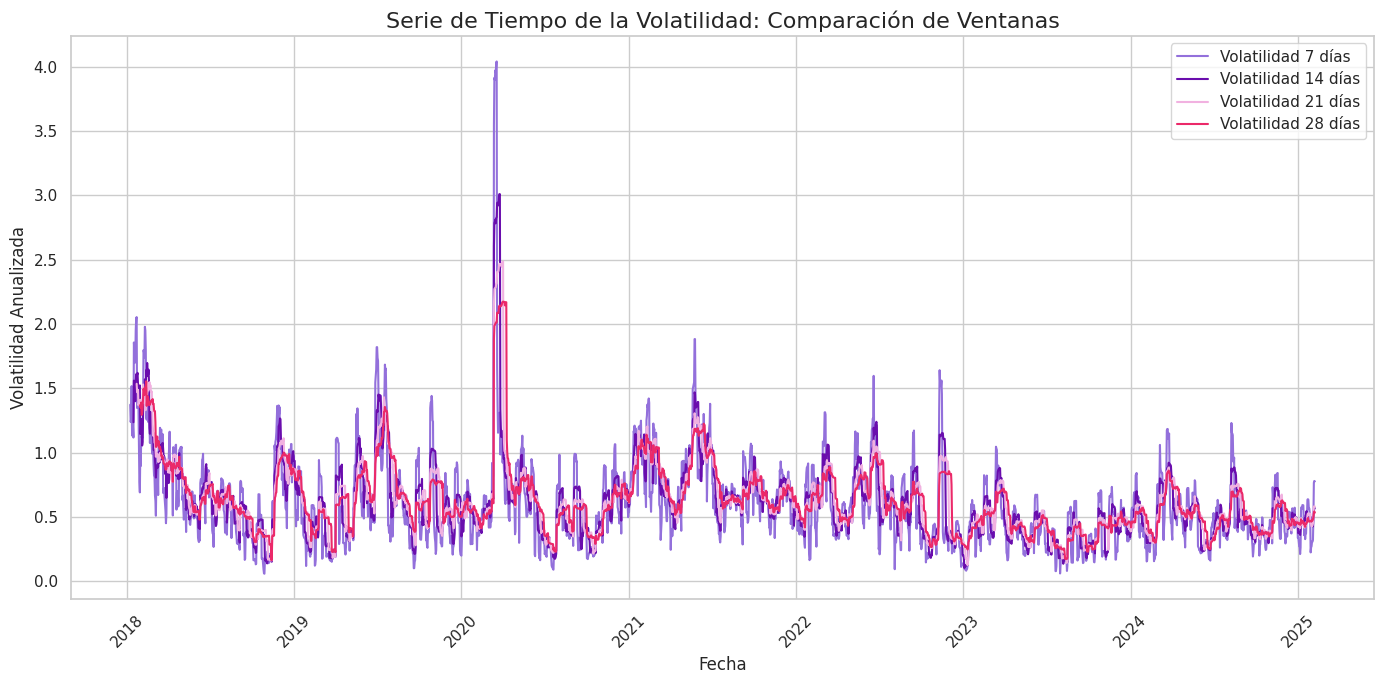

In [ ]:
colors = ['#9370DB', '#6a0dad', "#f1b1e0", "#eb2969"]

sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

for i, col in enumerate(volatilidad_cols):
    plt.plot(btc.index, btc[col], label=f'Volatilidad {ventanas[i]} días', color=colors[i])

plt.title('Serie de Tiempo de la Volatilidad: Comparación de Ventanas', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Volatilidad Anualizada', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

La **volatilidad anualizada** calculada con una ventana móvil de 30 días muestra claros **patrones de agrupamiento** en la serie temporal de BTC. Se destacan episodios de alta volatilidad:

- **Marzo 2020:** Volatilidad extrema asociada al crash por COVID-19.  
- **Mayo 2021:** Alta incertidumbre por restricciones regulatorias en China.  
- **Junio 2022:** Colapso de plataformas como Celsius y Terra/Luna.  

Estos picos evidencian que la volatilidad **no es constante**, sino que **tiende a persistir en el tiempo**, validando su uso como variable objetivo en modelos de predicción. La magnitud de los picos (hasta 1.6) indica que BTC puede experimentar **variaciones diarias de hasta ±10%** en periodos de tensión elevada.

## *Precio vs Volatilidad*

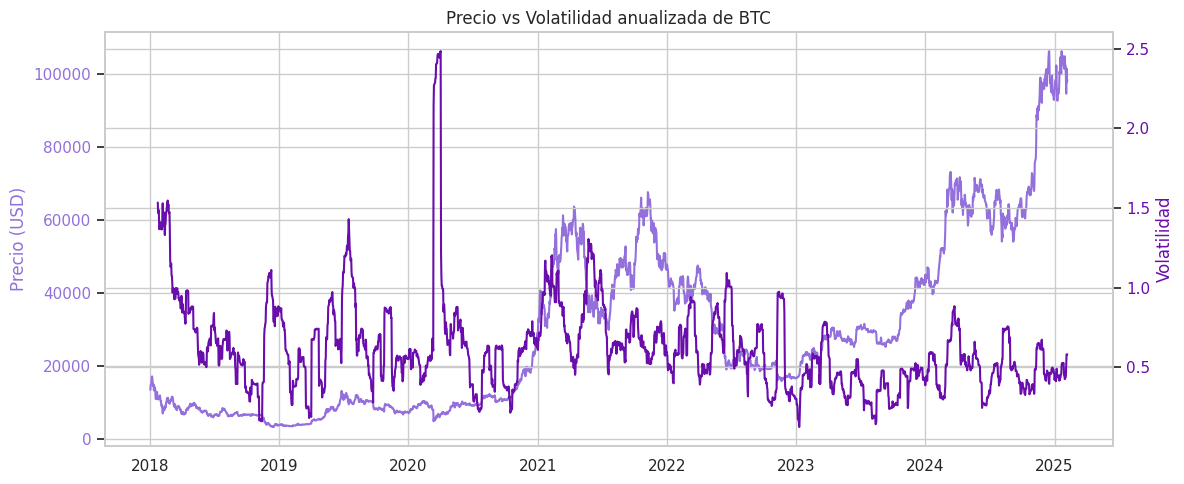

In [170]:
fig, ax1 = plt.subplots(figsize=(12, 5))

# Precio
ax1.plot(btc.index, btc['Close'], color='#9370DB', label='Precio BTC')
ax1.set_ylabel('Precio (USD)', color='#9370DB')
ax1.tick_params(axis='y', labelcolor='#9370DB')

# Volatilidad (eje secundario)
ax2 = ax1.twinx()
ax2.plot(btc.index, btc['Volatilidad_21d'], color='#6a0dad', label='Volatilidad anualizada')
ax2.set_ylabel('Volatilidad', color='#6a0dad')
ax2.tick_params(axis='y', labelcolor='#6a0dad')

plt.title("Precio vs Volatilidad anualizada de BTC")
fig.tight_layout()
plt.show()


El gráfico revela que la volatilidad anualizada de BTC (Se escogió de 21 días para el gráfico) no sigue linealmente al precio, sino que responde a la intensidad y frecuencia de los movimientos diarios. Esta observación justifica el modelado separado de la volatilidad como variable objetivo, y refuerza la necesidad de capturar sus patrones temporales mediante técnicas de aprendizaje profundo.

## *Correlación entre retorno absoluto y volatilidad (Cada Ventana)*

In [171]:
btc['AbsReturn'] = btc['LogReturn'].abs()
print("Correlación entre Retorno Absoluto y Volatilidades Históricas:\n")

# Se itera sobre cada columna de volatilidad
for col in volatilidad_cols:
    # Se seleccionan las dos columnas y se calcula la correlación
    correlation = btc[['AbsReturn', col]].corr().iloc[0, 1]
    print(f"- Correlación con {col}: {correlation:.4f}")



Correlación entre Retorno Absoluto y Volatilidades Históricas:

- Correlación con Volatilidad_7d: 0.4735
- Correlación con Volatilidad_14d: 0.4008
- Correlación con Volatilidad_21d: 0.3658
- Correlación con Volatilidad_28d: 0.3411


Se observa una **correlación positiva moderada**, especialmente en ventanas cortas (**7 y 14 días**), lo que indica que los **retornos absolutos diarios (AbsReturn)** tienden a coincidir con períodos de mayor volatilidad reciente. A medida que se amplía la ventana de cálculo, la correlación **disminuye gradualmente**, lo que sugiere que **AbsReturn captura mejor la volatilidad inmediata** que la acumulada en horizontes más largos.  

# **Conclusiones del EDA**

## 1. Características del Precio y los Retornos
- **Alta Volatilidad y Ciclos de Mercado**:  
  El precio de BTC muestra una volatilidad estructural muy alta, con ciclos alcistas y bajistas bien definidos entre 2018 y 2025.

- **Distribución No Normal de Retornos**:  
  Los retornos logarítmicos diarios no siguen una distribución normal, presentando:

  - **Asimetría Negativa**: Con un valor de `-1.16`, indica que las caídas abruptas son más frecuentes o intensas que las subidas.  
  - **Colas Pesadas (Leptocurtosis)**: La curtosis de `17.02` (muy superior a 3) revela una alta probabilidad de eventos extremos ("cisnes negros"), los cuales se correlacionan directamente con noticias del mundo real.


## 2. Comportamiento de la Volatilidad (Hallazgo Clave)
- **Agrupamiento de Volatilidad (Volatility Clustering)**:  
  Es el descubrimiento más importante. Períodos de alta volatilidad tienden a ser seguidos por más días volátiles, y períodos de calma son seguidos por más calma.

- **Confirmación Estadística**:  
  El fenómeno se confirma visualmente y, de forma más robusta, mediante:

  - **ACF de Retornos al Cuadrado**: Muestra una correlación significativa y persistente, indicando que la volatilidad de un día depende de la de los días anteriores.  
  - **Prueba de Ljung-Box**: Con un *p-valor* de `2.2e-07` para los retornos al cuadrado, se confirma estadísticamente la presencia de heterocedasticidad (varianza no constante).


## 3. Autocorrelación de las Series
- **Retornos (Precio)**: Presentan una autocorrelación muy baja, cercana a un comportamiento de ruido blanco, lo que respalda la hipótesis de eficiencia del mercado.  
- **Volatilidad (Retornos al Cuadrado)**: Muestra una dependencia temporal fuerte y clara, lo que la convierte en una variable predecible y un objetivo ideal para el modelado.


## 4. Implicaciones para el Modelado
- **Objetivo del Modelo**: El EDA justifica plenamente la decisión de modelar y predecir la volatilidad en lugar del precio.  
- **Métricas de Evaluación**: La naturaleza no normal de los retornos sugiere el uso de métricas robustas como **MAE** y **MAPE**.  

In [ ]:
features = ['Close', 'LogReturn']
features += [f'Volatilidad_{i}d' for i in [7, 14, 21, 28]]

df_final = btc[features].dropna().copy()

df_final

,Close,LogReturn,Volatilidad_7d,Volatilidad_14d,Volatilidad_21d,Volatilidad_28d
Date,,,,,,
2018-01-29,11251.00,-0.054395,0.690572,1.522041,1.371132,1.367343
2018-01-30,10237.51,-0.094399,1.005329,1.143258,1.410198,1.351515
2018-01-31,10285.10,0.004638,0.895483,1.142321,1.395937,1.348702
2018-02-01,9224.52,-0.108831,1.127962,1.259500,1.383471,1.388793
2018-02-02,8873.03,-0.038849,1.117298,1.223554,1.365130,1.292856
...,...,...,...,...,...,...
2025-02-02,99796.00,-0.024038,0.319643,0.426355,0.448729,0.480990
2025-02-03,94495.21,-0.054579,0.486452,0.504795,0.508193,0.498576
2025-02-04,101367.77,0.070206,0.764874,0.545473,0.581348,0.528412


In [ ]:
nombre_del_archivo = "btc_final.csv"

df_final.to_csv(nombre_del_archivo)

print(f"DataFrame guardado exitosamente como '{nombre_del_archivo}'")

DataFrame guardado exitosamente como 'btc_final.csv'
